# Example: Answering multiple choice questions

Guided prompting is useful for classification tasks, where it is useful to see both
how the model answers and how confident that it is in its answers.

In [13]:
import lmql
import lmql_demo.download as download
from rich.pretty import pprint

In [14]:

llama2_tokenizer = "llama2/llama-tokenizer.model"
mistral_tokenizer = "llama2/mistral-tokenizer.model"
model_filename = download.download_mistral()

The file 'llama2/mistral-7b-v0.1.Q4_K_M.gguf' already exists.


In [15]:
local_model = lmql.model(f"local:llama.cpp:{model_filename}", tokenizer=mistral_tokenizer)

# Answer SAT Sample Questions

This is a [sample language SAT question](https://www.princetonreview.com/college-advice/sat-practice-questions#!tab3) to demonstrate how we can leverage LMQL's ability to get probability distributions of tokens to answer test questions.

The advantage of getting the distribution rather than making the LLM generate the token is that sometimes the LLM will pick the less likely token, especially if the probailities are very close.

In [16]:
question = """After reading the passage below, choose the answer to each question that most 
effectively improves the quality of writing in the passage or that makes the passage 
conform to the conventions of standard written English. Many questions include a "NO CHANGE" 
option. Choose that option if you think the best choice is to leave the relevant portions of 
the passage as it is.

The speakers of what has come to be known as (1) Appalachian English has used a form of English 
that few can explain. Many scholars believe Appalachian pronunciation comes from Scots-Irish 
immigration, but (2) some theorizes that this dialect of English may be closer to what Londoners 
spoke in Elizabethan times. Trying to understand these changes (3) demonstrate that although 
we all technically speak English, we speak very different languages indeed.
"""

prompt_1 = """1.
(A) NO CHANGE
(B) Appalachian English uses
(C) Appalachian English use
(D) Appalachian English using
"""

prompt_2 = """2.
(A) NO CHANGE
(B) some theorized
(C) some have theorized
(D) some theorize
"""

prompt_3 = """3.
(A) NO CHANGE
(B) demonstrate that although we all technically spoke English, we speak
(C) demonstrates that although we all technically speak English, we might have been speaking
(D) demonstrates that although we all technically speak English, we speak
"""

In [17]:
@lmql.query
async def evaluate_question(question, prompt):
    '''lmql
    "{question}"
    "{prompt}"
    "The answer is[ANSWER]" distribution ANSWER in [" A", " B", " C", " D"]
    '''

In [18]:
lmql_response = await evaluate_question(question, prompt_1, model=local_model)

In [19]:
pprint(lmql_response)

LMQLResult(
│   prompt='After reading the passage below, choose the answer to each question that most \neffectively improves the quality of writing in the passage or that makes the passage \nconform to the conventions of standard written English. Many questions include a "NO CHANGE" \noption. Choose that option if you think the best choice is to leave the relevant portions of \nthe passage as it is.\n\nThe speakers of what has come to be known as (1) Appalachian English has used a form of English \nthat few can explain. Many scholars believe Appalachian pronunciation comes from Scots-Irish \nimmigration, but (2) some theorizes that this dialect of English may be closer to what Londoners \nspoke in Elizabethan times. Trying to understand these changes (3) demonstrate that although \nwe all technically speak English, we speak very different languages indeed.\n1.\n(A) NO CHANGE\n(B) Appalachian English uses\n(C) Appalachian English use\n(D) Appalachian English using\nThe answer is B',
│   variables={
│   │   'ANSWER': ' B',
│   │   'P(ANSWER)': [
│   │   │   (' A', 0.21177774452108036),
│   │   │   (' B', 0.32172428705079464),
│   │   │   (' C', 0.2500616456539004),
│   │   │   (' D', 0.2164363227742245)
│   │   ],
│   │   'log P(ANSWER)': [
│   │   │   (' A', -1.5522179291400433),
│   │   │   (' B', -1.1340603516253949),
│   │   │   (' C', -1.3860478089007855),
│   │   │   (' D', -1.5304588959369183)
│   │   ]
│   },
│   distribution_variable='ANSWER',
│   distribution_values=[' A', ' B', ' C', ' D'],
│   sequence=None
)

In [20]:
import matplotlib.pyplot as plt

In [21]:
async def answer_question(question, prompt):
    global local_model
    lmql_response = await evaluate_question(question, prompt, model=local_model)
    # Render a horizontal bar chart of the distribution
    distribution: list[tuple[str,float]] = lmql_response.variables['P(ANSWER)']
    answers, probabilities = zip(*distribution)
    fig, ax = plt.subplots()
    ax.barh(answers, probabilities)
    # Make the answer with the highest probability stand out
    max_index = probabilities.index(max(probabilities))
    ax.get_children()[max_index].set_color('r')
    ax.set_xlabel('Probability')
    # Set the title to the answer with the highest probability and its value
    ax.set_title(f'{answers[max_index]}: {probabilities[max_index]*100:.2f}%')
    plt.show()


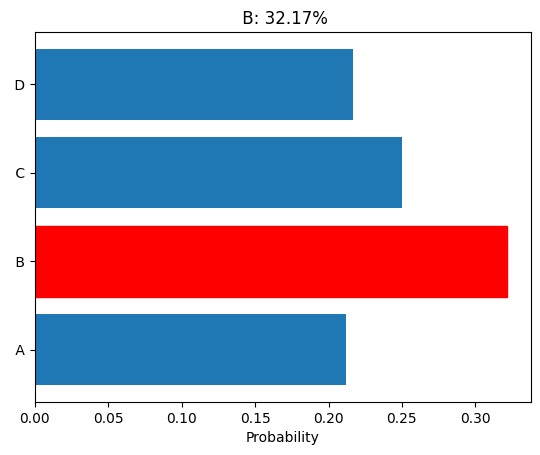

In [22]:
await answer_question(question, prompt_1)

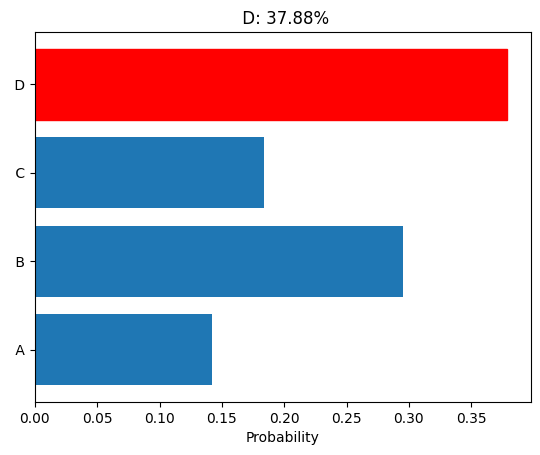

In [23]:
await answer_question(question, prompt_2)

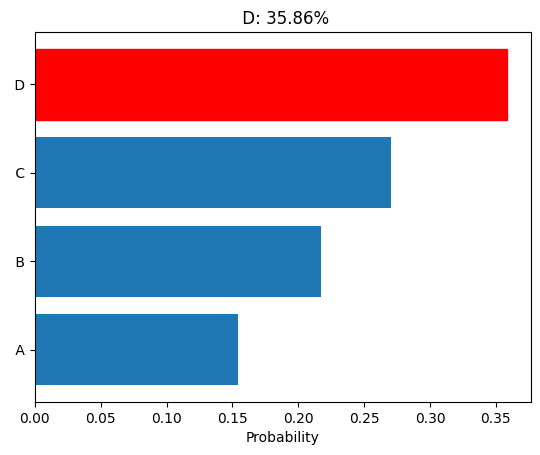

In [24]:
await answer_question(question, prompt_3)